# GUT of Imaging Results


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines

(32940,)
(3000,)
(3000,)


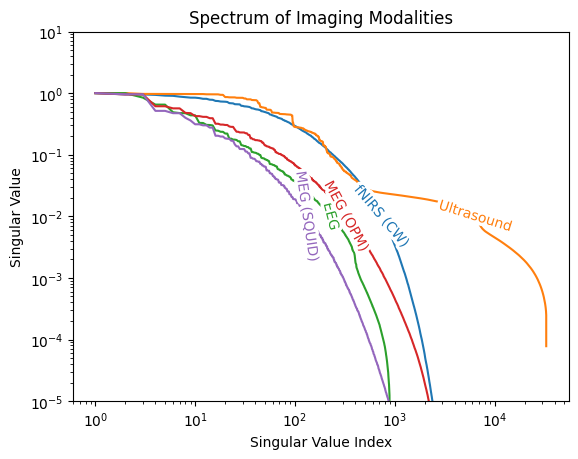

In [ ]:
from guti.data_utils import load_all_svds

# Load all SVD spectrums
all_svds = load_all_svds()

filenames_to_labels = {
    "eeg_openmeeg": "EEG",
    "fnirs_analytical_cw": "fNIRS (CW)",
    "us_analytical": "Ultrasound",
    "meg_opm": "MEG (OPM)",
    "meg_squid": "MEG (SQUID)",
}

# Plot all spectrums
ax = plt.gca()
for modality_name, (s, params) in all_svds.items():
    ax.plot(
        np.arange(1, len(s) + 1),
        s / s[0],
        label=filenames_to_labels.get(modality_name, modality_name),
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Singular Value Index")
ax.set_ylabel("Singular Value")
ax.set_title("Spectrum of Imaging Modalities")
ax.set_ylim(1e-5, 10)

# Use labellines instead of legend
labelLines(ax.get_lines(), zorder=2.5)

plt.savefig("spectrum.png")
plt.show()

In [28]:
from guti.core import get_bitrate_channel_capacity

snr_per_modalities = {
    "EEG": 100.0,
    "fNIRS (CW)": 100.0,
    "meg_opm": 100.0,
    "meg_squid": 100.0,
    "us_analytical": 100.0
}

time_resolution_per_modality = {
    "EEG": 10e-3,
    "fNIRS (CW)": 1.0,
    "meg_opm": 10e-3,
    "meg_squid": 10e-3,
    "us_analytical": 1.0,
}

channel_capacities = {}

# Plot all spectrums
for modality_name, (s, params) in all_svds.items():
    channel_capacity = get_bitrate_channel_capacity(s.astype(np.float64),
        snr_at_reference_nsensors=snr_per_modalities[modality_name],
        time_resolution=time_resolution_per_modality[modality_name]
    )
    if modality_name == "us_analytical":
        channel_capacity *= (1000/40)**3
    channel_capacities[modality_name] = channel_capacity

    print(f"{modality_name}: {channel_capacities[modality_name]:.2f} bits/s")




KeyError: 'fnirs_analytical_cw'